# Why does an increasing number of potential merging BBHs lead to stellar mergers at increasing metallicity

We've shown in [this notebook](./Endpoint_potential_DCO.ipynb) that if you look at the simulation with no BH kicks, the BBH yield still reduces towards higher metallicity, because the systems become stellar mergers instead. 

### In this notebook
We set out to plot the different types of stellar mergers that the potential DCO mergers experience


In [19]:
import numpy as np
import os 
import pandas as pd
import h5py as h5
import matplotlib.pyplot as plt
import colorsys
from matplotlib.gridspec import GridSpec

home_dir = os.path.expanduser("~") 
datar_root = home_dir + "/ceph/CompasOutput/v02.46.01/"#v02.35.02/"
sim_name = 'NewWinds_RemFryer2012'#' OldWinds_RemFryer2012  

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,20,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=SMALL_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


# Turn off natural name warning for panda tables (this is due to '@' and '>' in the COMPAS column names)
import warnings
from tables import NaturalNameWarning
warnings.filterwarnings('ignore', category=NaturalNameWarning)

######################################
# Helper function to make color darker
def darken_color(color, factor=0.8):
    r, g, b = (int(color[i:i+2], 16)/255 for i in (1, 3, 5))
    h, l, s = colorsys.rgb_to_hls(r, g, b)
    return '#%02x%02x%02x' % tuple(int(x*255) for x in colorsys.hls_to_rgb(h, l*factor, s))



In [20]:
####################################
# Take the base potential DCO progenitor table
prog_table_name = 'potential_DCO_progenitors_Allinfo.h5'

if os.path.isfile(datar_root+ f'{sim_name}/'+prog_table_name):
    potential_DCO_progenitors = pd.read_hdf(datar_root + f'{sim_name}/' + prog_table_name, key='All_DCO')
    print('Table exists, reading in... ',  potential_DCO_progenitors.info())
else:
    print('error, table doesnt exist, you should make it using "DataManipulation.ipynb" first')

potential_DCO_progenitors.reset_index(drop=True, inplace=True)
    

<class 'pandas.core.frame.DataFrame'>
Int64Index: 113772 entries, 0 to 113771
Data columns (total 95 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SEED                                  113772 non-null  uint64 
 1   Metallicity@ZAMS(1)                   113772 non-null  float64
 2   Stellar_Type(1)                       113772 non-null  int32  
 3   Stellar_Type(2)                       113772 non-null  int32  
 4   CE_Event_Counter                      113772 non-null  uint32 
 5   Mass@ZAMS(1)                          113772 non-null  float64
 6   Mass@ZAMS(2)                          113772 non-null  float64
 7   SemiMajorAxis@ZAMS                    113772 non-null  float64
 8   Merger                                113772 non-null  uint8  
 9   Merger_At_Birth                       113772 non-null  uint8  
 10  Unbound                               113772 non-null  uint8  
 11  

### Split your table between merging BBH/BHNS/NSNS

In [21]:
with h5.File(datar_root+f'{sim_name}/COMPAS_Output_combinedZ.h5', 'r') as All_data:
    DCO = All_data['BSE_Double_Compact_Objects']
    st1 = DCO['Stellar_Type(1)'][()]
    st2 = DCO['Stellar_Type(2)'][()]
    dco_merger = DCO['Merges_Hubble_Time'][()]  
    DCO_seed = DCO['SEED'][()]
    # Now I want to add a bool that tells me if this system is ever a BBH, BHNS or BNS progenitor
    BBH_bool = np.logical_and(st1 == 14,st2 == 14)
    BHNS_bool = np.logical_or(np.logical_and(st1 == 13,st2 == 14),
                            np.logical_and(st1 == 14,st2 == 13) )
    NSNS_bool = np.logical_and(st1 == 13,st2 == 13)
    merger_bool = dco_merger == 1

    # Split our potential DCO progenitors into BBH, BHNS and NSNS progenitors
    potential_BBH_progenitors  = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BBH_bool*merger_bool]) )]
    potential_BHNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[BHNS_bool*merger_bool]) )]
    potential_NSNS_progenitors = potential_DCO_progenitors[np.in1d(potential_DCO_progenitors['SEED'], np.unique(DCO_seed[NSNS_bool*merger_bool]) )]



## Plot stellar mergers for each of the DCO flavours

In [22]:
metallicities = np.unique(potential_DCO_progenitors['Metallicity@ZAMS(1)'])
print('metallicities', metallicities)   
Z_Zsun = np.log10(np.array(metallicities)/0.014)


metallicities [0.0001     0.00017321 0.0003     0.00054772 0.001      0.002
 0.004      0.00632456 0.01       0.01414214 0.02       0.03      ]


In [23]:
def get_merger_numbers(table = potential_DCO_progenitors):

    # CASE A: Stellar type1/2 == 1 for star MT 1/2
    case_A_bool1    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(1)<MT'] == 1, table['MT_lead_to_merger_RLOF(1)>MT'] == 1)
    case_A_bool2    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(2)<MT'] == 1,  table['MT_lead_to_merger_RLOF(2)>MT'] == 1)
    case_A_bool     = np.logical_or(case_A_bool1, case_A_bool2)
    table.loc[case_A_bool, 'merger_from_case_A_donor'] = True
    table.loc[~case_A_bool, 'merger_from_case_A_donor'] = False

    # CASE B: Stellar type1/2 == 2 for star MT 1/2
    case_B_bool1    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(1)<MT'] == 2, table['MT_lead_to_merger_RLOF(1)>MT'] == 1)
    case_B_bool2    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(2)<MT'] == 2, table['MT_lead_to_merger_RLOF(2)>MT'] == 1)
    case_B_bool     = np.logical_or(case_B_bool1, case_B_bool2)
    table.loc[case_B_bool, 'merger_from_case_B_donor'] = True
    table.loc[~case_B_bool, 'merger_from_case_B_donor'] = False

    # CASE C: Stellar type1/2 > 2 for star MT 1/2
    case_C_bool1    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(1)<MT'] > 2, table['MT_lead_to_merger_RLOF(1)>MT'] == 1)
    case_C_bool2    = np.logical_and(table['MT_lead_to_merger_Stellar_Type(2)<MT'] > 2, table['MT_lead_to_merger_RLOF(2)>MT'] == 1)
    case_C_bool     = np.logical_or(case_C_bool1, case_C_bool2)
    table.loc[case_C_bool, 'merger_from_case_C_donor'] = True
    table.loc[~case_C_bool, 'merger_from_case_C_donor'] = False

    # Was the mass transfer that lead to the merger, stable or unstable MT?
    MT_lead_to_merger_stable = table['MT_lead_to_merger_CEE>MT'] == 0
    # table['MT_lead_to_merger_stable'] = np.full(len(table), False)
    table.loc[~MT_lead_to_merger_stable, 'MT_lead_to_merger_stable'] = False
    table.loc[MT_lead_to_merger_stable, 'MT_lead_to_merger_stable'] = True

    ################################################
    grouped_byZ = table.groupby('Metallicity@ZAMS(1)')

    N_tot_DCO_prog          = grouped_byZ.size() # total number in this table (per Z)
    N_mergers               = grouped_byZ['Merger'].apply(lambda x: (x==1).sum()) # number of stellar mergers in total

    N_first_mt1_is_merger   = grouped_byZ['firstMT_RLOF_Merger'].apply(lambda x: (x==1).sum())
    N_first_mt2_is_merger   = grouped_byZ['star2_firstMT_RLOF_Merger'].apply(lambda x: (x==1).sum())
    
    # print('N_mergers', N_mergers)
    # print('N_first_mt1_is_merger',N_first_mt1_is_merger, 'N_first_mt2_is_merger', N_first_mt2_is_merger)
    # print('difference: ', N_mergers - (N_first_mt1_is_merger + N_first_mt2_is_merger))

    N_optimistic_CE     = grouped_byZ['Optimistic_CE'].apply(lambda x: (x==1).sum()) # optimistic CE (= CE from case B donor)
    N_merger_at_birth   = grouped_byZ['Merger_At_Birth'].apply(lambda x: (x==1).sum()) # stars that merge at birth

    N_caseA_mergers         = grouped_byZ['merger_from_case_A_donor'].apply(lambda x: (x==1).sum())
    N_caseA_mergers_stable  = grouped_byZ.apply(lambda x: ((x['merger_from_case_A_donor']==1) & (x['MT_lead_to_merger_stable']==True)).sum())
    N_caseA_mergers_CE      = grouped_byZ.apply(lambda x: ((x['merger_from_case_A_donor']==1) & (x['MT_lead_to_merger_stable']==False)).sum())

    N_caseB_mergers         = grouped_byZ['merger_from_case_B_donor'].apply(lambda x: (x==1).sum())
    N_caseB_mergers_stable  = grouped_byZ.apply(lambda x: ((x['merger_from_case_B_donor']==1) & (x['MT_lead_to_merger_stable']==True)).sum())
    N_caseB_mergers_CE      = grouped_byZ.apply(lambda x: ((x['merger_from_case_B_donor']==1) & (x['MT_lead_to_merger_stable']==False)).sum())

    N_caseC_mergers         = grouped_byZ['merger_from_case_C_donor'].apply(lambda x: (x==1).sum())
    N_caseC_mergers_stable  = grouped_byZ.apply(lambda x: ((x['merger_from_case_C_donor']==1) & (x['MT_lead_to_merger_stable']==True)).sum())
    N_caseC_mergers_CE      = grouped_byZ.apply(lambda x: ((x['merger_from_case_C_donor']==1) & (x['MT_lead_to_merger_stable']==False)).sum())

    case_ABC = [N_caseA_mergers, N_caseA_mergers_stable, N_caseA_mergers_CE, N_caseB_mergers, N_caseB_mergers_stable, N_caseB_mergers_CE, N_caseC_mergers, N_caseC_mergers_stable, N_caseC_mergers_CE]

    return  N_tot_DCO_prog, N_mergers, N_first_mt1_is_merger, N_first_mt2_is_merger, N_optimistic_CE, N_merger_at_birth, case_ABC


N_tot_DCO_prog, N_mergers, N_first_mt1_is_merger, N_first_mt2_is_merger, N_optimistic_CE, N_merger_at_birth, case_ABC = get_merger_numbers(table = potential_DCO_progenitors)

N_caseA_mergers, N_caseA_mergers_stable, N_caseA_mergers_CE, N_caseB_mergers, N_caseB_mergers_stable, N_caseB_mergers_CE, N_caseC_mergers, N_caseC_mergers_stable, N_caseC_mergers_CE = case_ABC


/tmp/ipykernel_3007215/343471259.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.loc[case_A_bool, 'merger_from_case_A_donor'] = True
/tmp/ipykernel_3007215/343471259.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  table.loc[case_B_bool, 'merger_from_case_B_donor'] = True
/tmp/ipykernel_3007215/343471259.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation

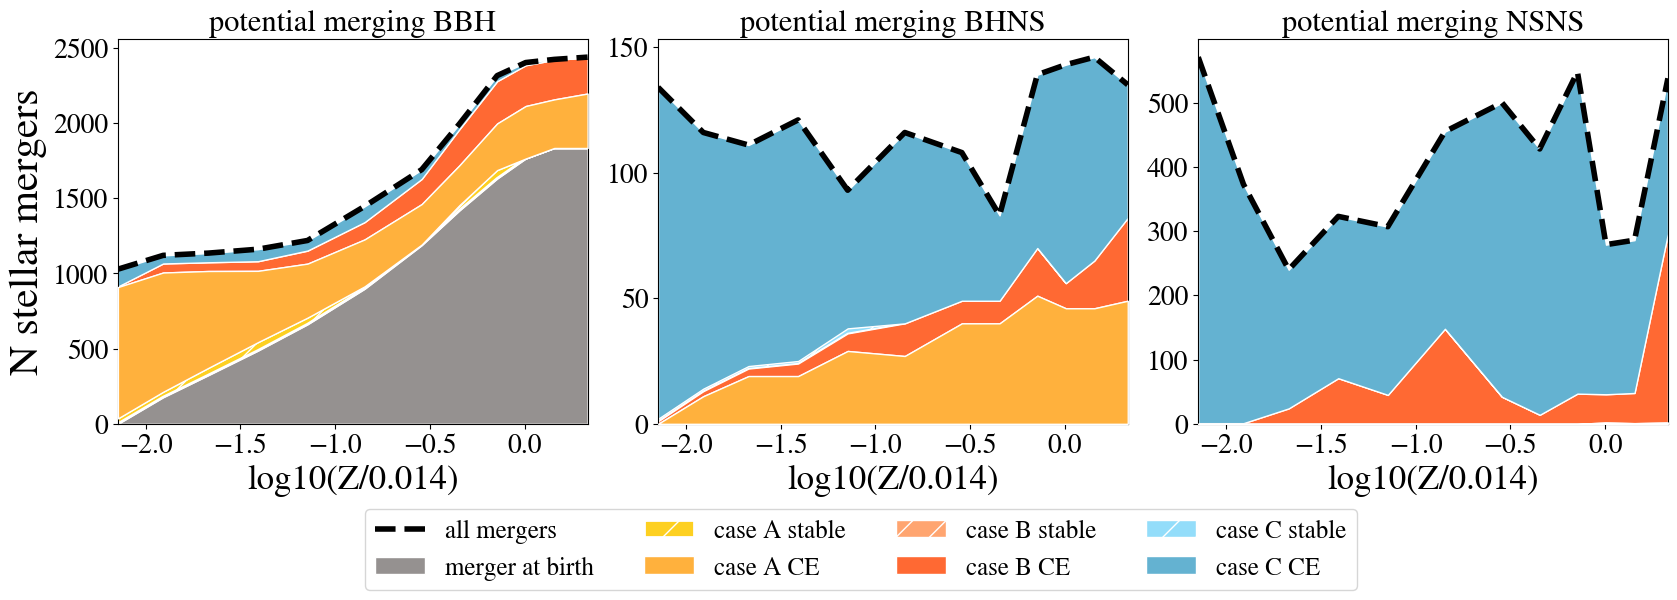

In [24]:
###########################################
# Create a figure
from matplotlib import hatch

fig = plt.figure(figsize=(20, 5))

# Create a GridSpec with 1 row and 3 columns
gs = GridSpec(1, 3, figure=fig)

# Create 3 small subplots on a line
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# List of panda tables of pot DCO progenitors
titles = ["BBH", "BHNS", "NSNS"]
dfs = [potential_BBH_progenitors, potential_BHNS_progenitors, potential_NSNS_progenitors]

# Loop over the axes and dataframes
for ax, df, title in zip(axes, dfs, titles):
    ax.plot(1,1)
    N_tot_DCO_prog, N_mergers, N_first_mt1_is_merger, N_first_mt2_is_merger, N_optimistic_CE, N_merger_at_birth, case_ABC = get_merger_numbers(table = df)
    N_caseA_mergers, N_caseA_mergers_stable, N_caseA_mergers_CE, N_caseB_mergers, N_caseB_mergers_stable, N_caseB_mergers_CE, N_caseC_mergers, N_caseC_mergers_stable, N_caseC_mergers_CE = case_ABC

    ax.plot(Z_Zsun, N_mergers, color='k', label='all mergers', ls = '--', lw = 4,alpha = 1)

    # Normalize or abs numbers?
    norm = 1. # N_tot_DCO_prog

    bottom = np.zeros(len(Z_Zsun))

    # Stellar merger at birth 
    ax.fill_between(Z_Zsun, bottom, N_merger_at_birth, color='#959190', edgecolor='white', lw = 1, label='merger at birth', alpha = 1)
    bottom += N_merger_at_birth

    # Case A mergers
    ax.fill_between(Z_Zsun, bottom, (bottom + N_caseA_mergers_stable)/norm, color='#fdd021', edgecolor='white', hatch='/', lw = 2, label='case A stable', alpha = 1)
    bottom += N_caseA_mergers_stable
    ax.fill_between(Z_Zsun, bottom, (bottom + N_caseA_mergers_CE)/norm, color='#ffb13d',edgecolor='white', lw = 1, label='case A CE', alpha = 1, zorder = 10)
    bottom += N_caseA_mergers_CE

    # Case B mergers
    ax.fill_between(Z_Zsun, bottom, (bottom + N_caseB_mergers_stable)/norm, color='#FFA570', edgecolor='white', hatch='/', lw = 1, label='case B stable', alpha = 1)
    bottom += N_caseB_mergers_stable
    ax.fill_between(Z_Zsun, bottom, (bottom + N_caseB_mergers_CE)/norm, color='#FF6933', edgecolor='white', lw = 1, label='case B CE', alpha = 1)
    bottom += N_caseB_mergers_CE

    # Case C mergers
    ax.fill_between(Z_Zsun, bottom, (bottom + N_caseC_mergers_stable)/norm, color='#93ddfa', edgecolor='white', hatch='/', lw = 1, label='case C stable', alpha = 1)
    bottom += N_caseC_mergers_stable
    ax.fill_between(Z_Zsun, bottom, (bottom + N_caseC_mergers_CE)/norm, color='#64b2d1', edgecolor='white', lw = 1, label='case C CE', alpha = 1)
    # 284051 1B78AF
    
    # ax.plot(Z_Zsun, N_optimistic_CE, color='#BC0000', lw = 2, label='optimistic CE', alpha = 1)

    ax.set_title(f'potential merging {title}', fontsize = 22) #7x{N_tot_DCO_prog[0.0001]}
    ax.set_xlim(np.log10(1e-4/0.014),np.log10(0.03/0.014))
    ax.set_ylim(0,)
    ax.set_xlabel('log10(Z/0.014)', fontsize = 25)

#########################
# plotvalues
fig.subplots_adjust(wspace=0.15)

axes[0].set_ylabel("N stellar mergers", fontsize = 30)
axes[0].legend(bbox_to_anchor=(0.5, -0.19), loc='upper left', fontsize = 18, ncols = 4)

plt.savefig(f'../plots/Stellar_mergers_{sim_name}.pdf', bbox_inches='tight')
plt.show()


In [ ]:
    # # Count Case A, B, C mass transfer
    # # What is the stellar type of the donor for the MT that lead to a stellar merger? 
    # star_1_is_RLOF = table['mergingMT_RLOF(1)>MT'] == 1
    # type_1rlof = table['mergingMT_Stellar_Type(1)<MT'][star_1_is_RLOF]

    # # When star 2 is the MT star
    # star_2_is_RLOF = table['mergingMT_RLOF(2)>MT'] == 1
    # type_2rlof = table['mergingMT_Stellar_Type(2)<MT'][star_2_is_RLOF]
    

    # # What is the stellar type of the donor for the MT that lead to a stellar merger? 
    # star_1_is_RLOF = table['mergingMT_RLOF(1)>MT'] == 1
    # type_1rlof = table['mergingMT_Stellar_Type(1)<MT'][star_1_is_RLOF]

    # # When star 2 is the MT star
    # star_2_is_RLOF = table['mergingMT_RLOF(2)>MT'] == 1
    # type_2rlof = table['mergingMT_Stellar_Type(2)<MT'][star_2_is_RLOF]
    
    # # Combine them into one array
    # type_of_MT_star = np.concatenate((type_1rlof, type_2rlof))
    # MT_type, counts = np.unique(type_of_MT_star, return_counts = True)
    # print(MT_type, counts)
    # # count the case a, b, c donors
    # case_A_donor_merger = counts[(MT_type == 0) | (MT_type == 1)].sum()
    # case_B_donor_merger = counts[MT_type == 2].sum()
    # case_C_donor_merger = counts[MT_type > 2].sum()